<a href="https://colab.research.google.com/github/ghassantaleb/loyalty-landscape-analysis/blob/main/loyalty_landscape_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

data = pd.read_csv('/content/marketing_campaign.csv', delimiter='\t')

data.head()

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [3]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')


In [4]:
import datetime

current_date = datetime.datetime.now()
data['Customer_Tenure'] = (current_date - data['Dt_Customer']).dt.days


In [5]:
# Assign the filled 'Income' column back to the DataFrame
data['Income'] = data['Income'].fillna(data['Income'].median())


In [6]:
data.isnull().sum()  # Check for remaining missing values


,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,0
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntWines,0


In [7]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Scale continuous variables
data[['Income', 'MntWines', 'MntMeatProducts']] = scaler.fit_transform(data[['Income', 'MntWines', 'MntMeatProducts']])

In [8]:

# Recency: Calculate days since the last purchase
# Assuming today is the reference point for calculating recency
import datetime
today = datetime.datetime.now()

# Group by customer ID and calculate metrics
rm = data.groupby('ID').agg({
    'Dt_Customer': lambda x: (today - x.max()).days,  # Recency: days since last purchase
    'MntWines': 'sum',  # Monetary: sum of MntWines (or your chosen monetary metric)
})

# Rename columns for clarity
rm = rm.rename(columns={'Dt_Customer': 'Recency', 'MntWines': 'Monetary'})
rm = rm.reset_index()

# Renaming columns for clarity
rm.columns = ['CustomerID', 'Recency', 'Monetary']
rm.head()

,CustomerID,Recency,Monetary
0,0,4196,-0.192961
1,1,3789,0.475643
2,9,4455,-0.733787
3,13,4117,-0.846707
4,17,4071,0.989724


In [11]:
# Assign scores from 1 to 5 for each RM metric (higher is better)
rm['Recency_Score'] = pd.qcut(rm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rm['Monetary_Score'] = pd.qcut(rm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Create an overall RM score
rm['RM_Score'] = rm['Recency_Score'].astype(str) + rm['Monetary_Score'].astype(str)

rm.head()


,CustomerID,Recency,Monetary,Recency_Score,Monetary_Score,RM_Score
0,0,4196,-0.192961,3,3,33
1,1,3789,0.475643,5,4,54
2,9,4455,-0.733787,1,2,12
3,13,4117,-0.846707,3,2,32
4,17,4071,0.989724,3,5,35


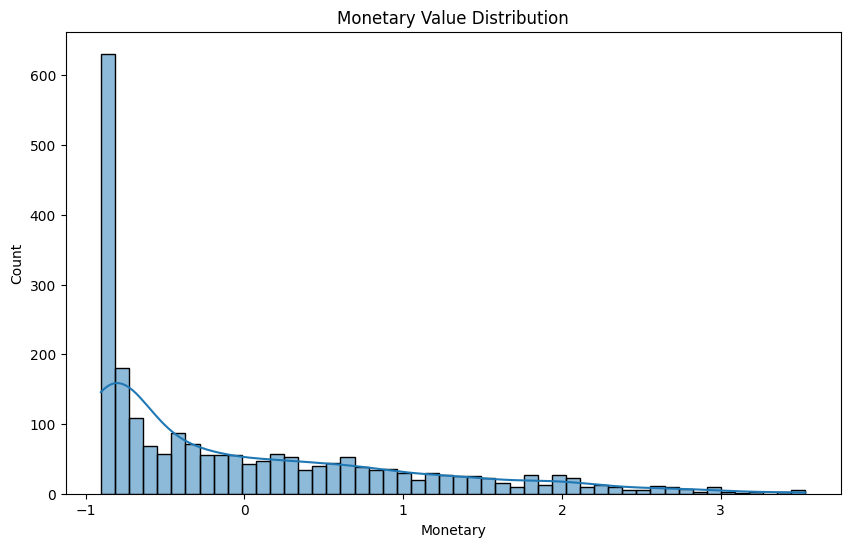

In [13]:
# Check the distribution of Monetary values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(rm['Monetary'], bins=50, kde=True)
plt.title('Monetary Value Distribution')
plt.show()


In [14]:
# Define a function to classify customers into loyalty segments based on RM scores
def loyalty_segment_rm(df):
    if df['RM_Score'] in ['55', '54', '45', '44']:  # High Recency and Monetary
        return 'Champion'
    elif df['RM_Score'] in ['53', '52', '43', '42', '35', '34', '33']:  # Moderate Recency and Monetary
        return 'Loyal Customer'
    elif df['RM_Score'] in ['51', '41', '32', '31', '25', '24', '23', '22']:  # Recent but low Monetary or vice versa
        return 'Potential Loyalist'
    elif df['RM_Score'] in ['21', '15', '14', '13', '12']:  # Low Recency or Low Monetary
        return 'At Risk'
    else:
        return 'Lost Customer'  # Very low Recency and Monetary

# Apply the function to classify each customer
rm['Segment'] = rm.apply(loyalty_segment_rm, axis=1)

# Display the segmentation results
segment_counts = rm['Segment'].value_counts()
rm.head(), segment_counts



(   CustomerID  Recency  Monetary Recency_Score Monetary_Score RM_Score  \
 0           0     4196 -0.192961             3              3       33   
 1           1     3789  0.475643             5              4       54   
 2           9     4455 -0.733787             1              2       12   
 3          13     4117 -0.846707             3              2       32   
 4          17     4071  0.989724             3              5       35   
 
               Segment  
 0      Loyal Customer  
 1            Champion  
 2             At Risk  
 3  Potential Loyalist  
 4      Loyal Customer  ,
 Segment
 Potential Loyalist    752
 Loyal Customer        649
 At Risk               460
 Champion              307
 Lost Customer          72
 Name: count, dtype: int64)

<ipython-input-15-326ecc136baa>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=rm, order=rm['Segment'].value_counts().index, palette='viridis')


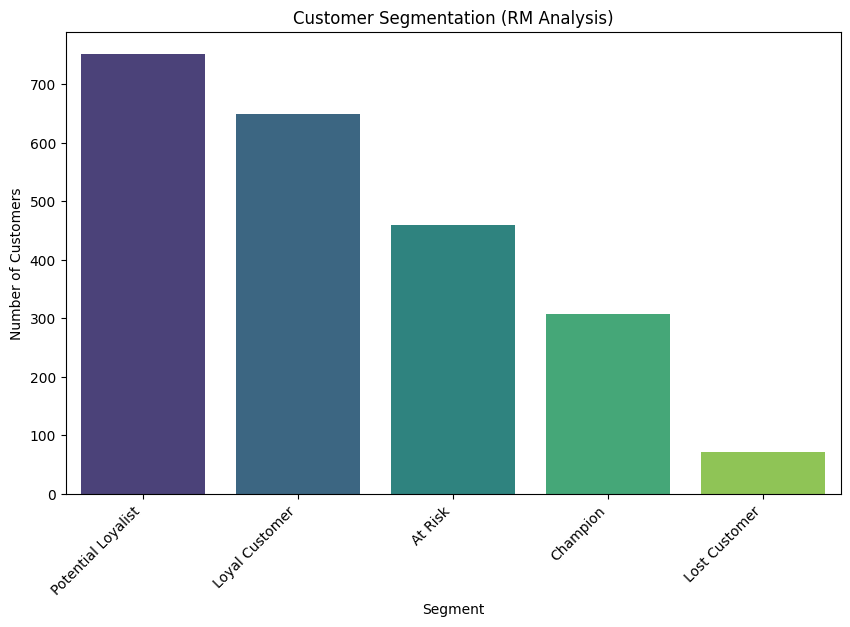

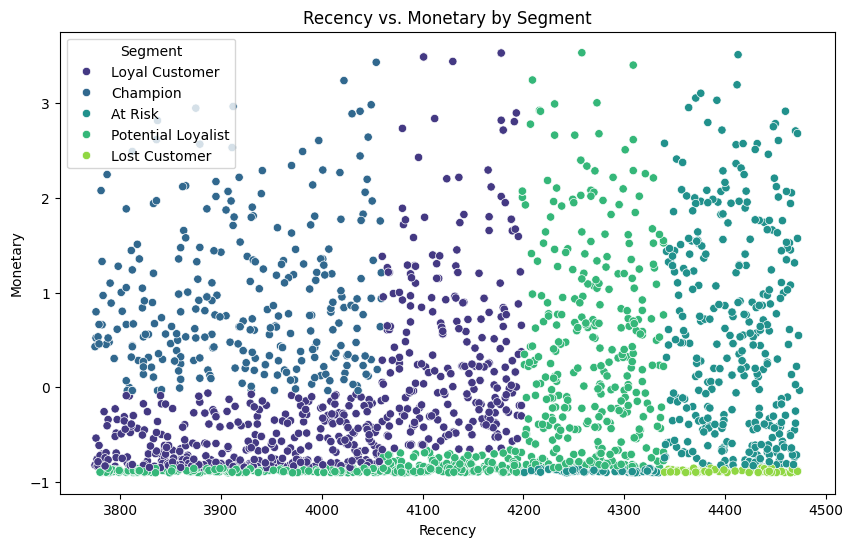

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of segments
plt.figure(figsize=(10, 6))
sns.countplot(x='Segment', data=rm, order=rm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segmentation (RM Analysis)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Optional: Plot Recency vs. Monetary with segment colors
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Segment', data=rm, palette='viridis')
plt.title('Recency vs. Monetary by Segment')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the features for clustering (Recency and Monetary)
X = rm[['Recency', 'Monetary']]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

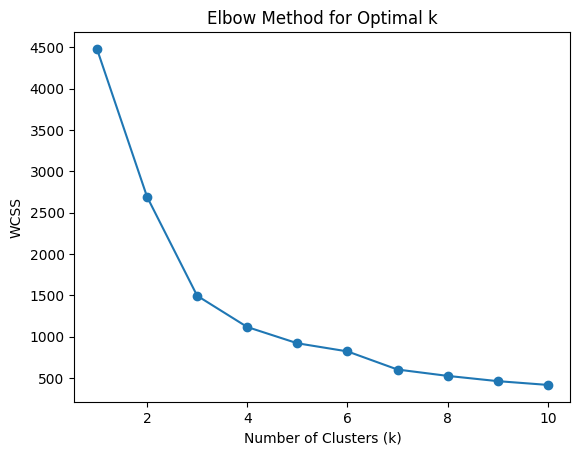

In [17]:
import matplotlib.pyplot as plt

wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [18]:
k = 3

kmeans_k3 = KMeans(n_clusters=k, random_state=42)
rm_k3 = rm.copy()  # Create a copy of 'rm' for k=3
rm_k3['Cluster'] = kmeans_k3.fit_predict(X_scaled)

             Recency  Monetary
Cluster                       
0        4291.991463 -0.458326
1        3939.491909 -0.427940
2        4212.336714  1.566993


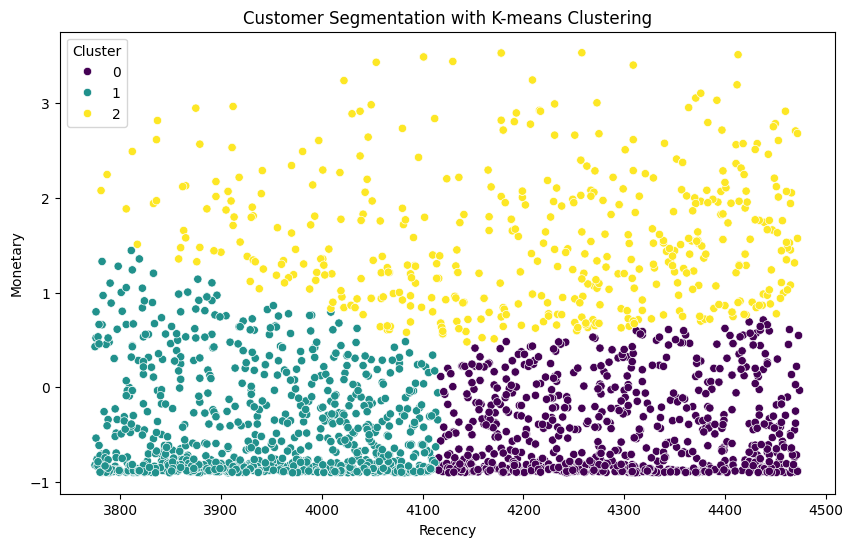

In [20]:
# Analyze cluster characteristics (e.g., mean Recency and Monetary for each cluster)
cluster_means = rm_k3.groupby('Cluster')[['Recency', 'Monetary']].mean()
print(cluster_means)

# Visualize the clusters (e.g., scatter plot of Recency vs. Monetary with cluster colors)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm_k3, palette='viridis')
plt.title('Customer Segmentation with K-means Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [21]:
k = 4

kmeans_k4 = KMeans(n_clusters=k, random_state=42)
rm_k4 = rm.copy()  # Create a copy of 'rm' for k=4
rm_k4['Cluster'] = kmeans_k4.fit_predict(X_scaled)

             Recency  Monetary
Cluster                       
0        4289.577215 -0.487166
1        3946.430429 -0.642333
2        4325.430233  1.567401
3        3965.890208  1.007801


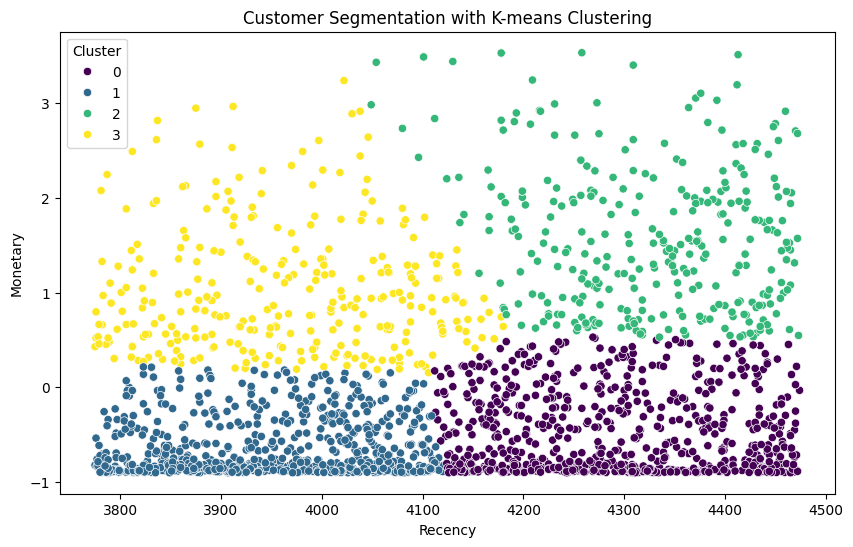

In [23]:
# Analyze cluster characteristics (e.g., mean Recency and Monetary for each cluster)
cluster_means = rm_k4.groupby('Cluster')[['Recency', 'Monetary']].mean()
print(cluster_means)

# Visualize the clusters (e.g., scatter plot of Recency vs. Monetary with cluster colors)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm_k4, palette='viridis')
plt.title('Customer Segmentation with K-means Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

Cluster Means (k=3):
              Recency  Monetary
Cluster                       
0        4291.991463 -0.458326
1        3939.491909 -0.427940
2        4212.336714  1.566993

Cluster Means (k=4):
              Recency  Monetary
Cluster                       
0        4289.577215 -0.487166
1        3946.430429 -0.642333
2        4325.430233  1.567401
3        3965.890208  1.007801

Inertia (k=3): 1494.8683266083642
Inertia (k=4): 1116.7274012129203

Silhouette Score (k=3): 0.4402836872922803
Silhouette Score (k=4): 0.4448616203729451


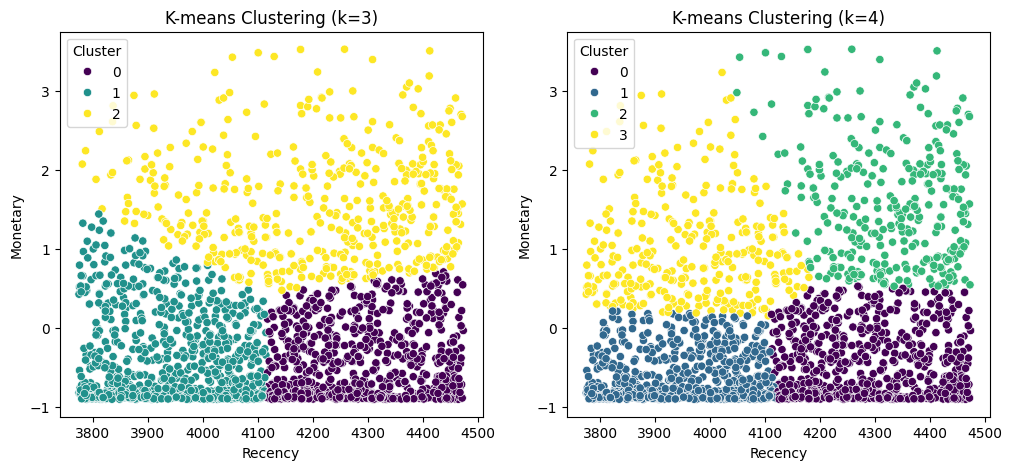

In [24]:
# Calculate and compare cluster characteristics
cluster_means_k3 = rm_k3.groupby('Cluster')[['Recency', 'Monetary']].mean()
cluster_means_k4 = rm_k4.groupby('Cluster')[['Recency', 'Monetary']].mean()
print("Cluster Means (k=3):\n", cluster_means_k3)
print("\nCluster Means (k=4):\n", cluster_means_k4)

# Calculate and compare internal evaluation metrics
inertia_k3 = kmeans_k3.inertia_  # Assuming 'kmeans_k3' is your KMeans object for k=3
inertia_k4 = kmeans_k4.inertia_  # Assuming 'kmeans_k4' is your KMeans object for k=4
print("\nInertia (k=3):", inertia_k3)
print("Inertia (k=4):", inertia_k4)

from sklearn.metrics import silhouette_score
silhouette_k3 = silhouette_score(X_scaled, rm_k3['Cluster'])
silhouette_k4 = silhouette_score(X_scaled, rm_k4['Cluster'])
print("\nSilhouette Score (k=3):", silhouette_k3)
print("Silhouette Score (k=4):", silhouette_k4)

# Visualize the clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm_k3, palette='viridis')
plt.title('K-means Clustering (k=3)')
plt.subplot(1, 2, 2)
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm_k4, palette='viridis')
plt.title('K-means Clustering (k=4)')
plt.show()

In [28]:
k = 5

kmeans_k5 = KMeans(n_clusters=k, random_state=42)
rm_k5 = rm.copy()  # Create a copy of 'rm' for k=5
rm_k5['Cluster'] = kmeans_k5.fit_predict(X_scaled)

             Recency  Monetary
Cluster                       
0        4291.614754 -0.686461
1        3946.438482 -0.644473
2        4315.811927  2.042683
3        3945.630363  1.008966
4        4286.049275  0.464049


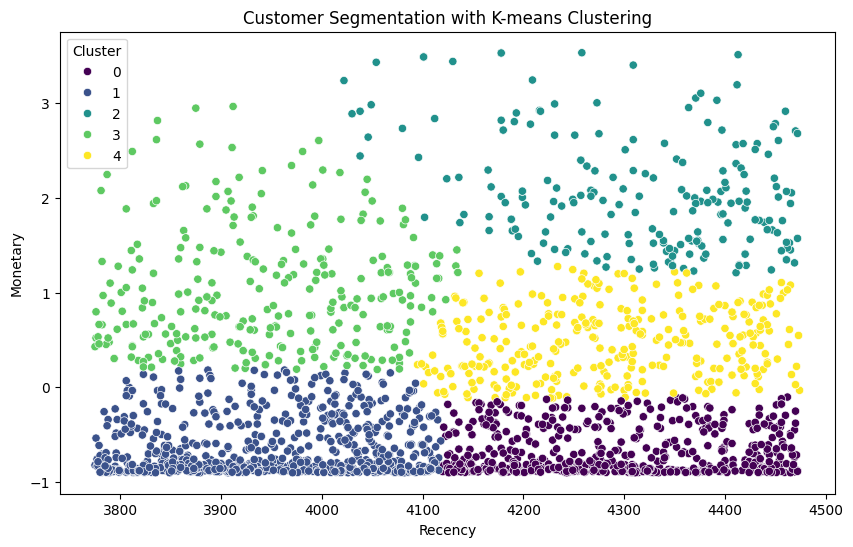

In [29]:
# Analyze cluster characteristics (e.g., mean Recency and Monetary for each cluster)
cluster_means = rm_k5.groupby('Cluster')[['Recency', 'Monetary']].mean()
print(cluster_means)

# Visualize the clusters (e.g., scatter plot of Recency vs. Monetary with cluster colors)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rm_k5, palette='viridis')
plt.title('Customer Segmentation with K-means Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [30]:
from sklearn.metrics import silhouette_score
silhouette_k5 = silhouette_score(X_scaled, rm_k5['Cluster'])
print("\nSilhouette Score (k=5):", silhouette_k5)


Silhouette Score (k=5): 0.4197273133878298


count    307.000000
mean       0.920149
std        0.760855
min       -0.035468
25%        0.318149
50%        0.734169
75%        1.332941
max        3.432356
Name: Monetary, dtype: float64


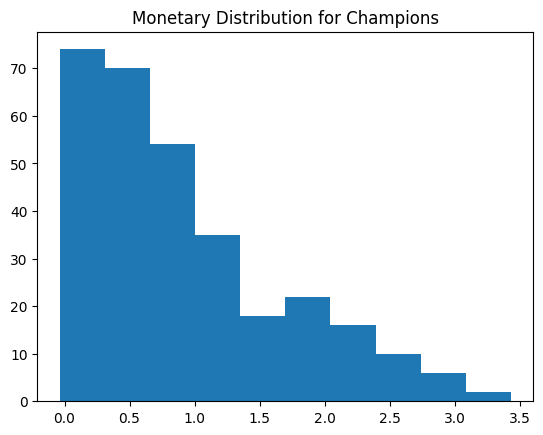

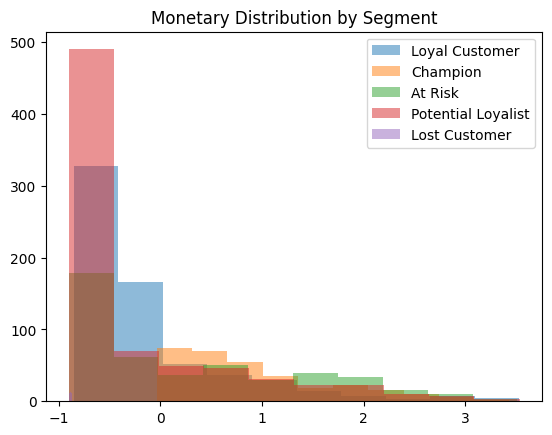

In [32]:
# Filter the data for the 'Champions' segment
champions_segment = rm[rm['Segment'] == 'Champion']

# Analyze the distribution of Income for Champions
champions_income = champions_segment['Monetary']
print(champions_income.describe())  # Descriptive statistics
plt.hist(champions_income)  # Histogram
plt.title('Monetary Distribution for Champions')
plt.show()

# Compare Income distribution of Champions with other segments
for segment in rm['Segment'].unique():
    segment_data = rm[rm['Segment'] == segment]
    plt.hist(segment_data['Monetary'], alpha=0.5, label=segment)
plt.title('Monetary Distribution by Segment')
plt.legend()
plt.show()


count    649.000000
mean      -0.175406
std        0.801076
min       -0.852650
25%       -0.742702
50%       -0.418801
75%       -0.020610
max        3.530418
Name: Monetary, dtype: float64


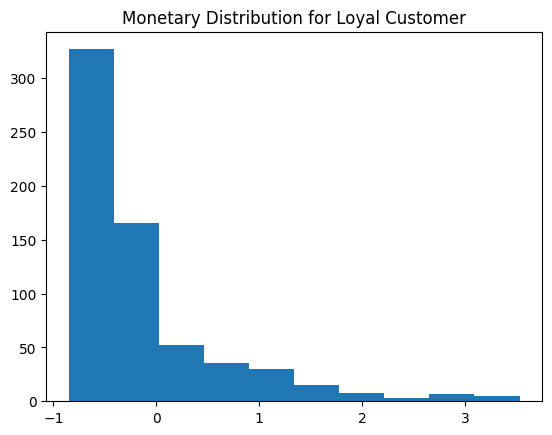

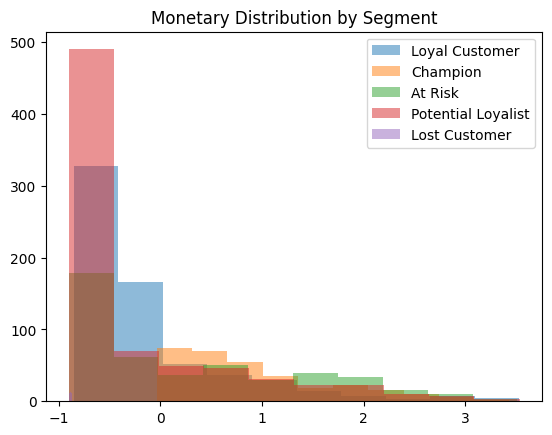

In [35]:
# Filter the data for the 'Loyal Customer' segment
Loyal_Customer_segment = rm[rm['Segment'] == 'Loyal Customer']

# Analyze the distribution of Income for Loyal Customer
Loyal_Customer_income = Loyal_Customer_segment['Monetary']
print(Loyal_Customer_income.describe())  # Descriptive statistics
plt.hist(Loyal_Customer_income)  # Histogram
plt.title('Monetary Distribution for Loyal Customer')
plt.show()

# Compare Income distribution of Loyal Customer with other segments
for segment in rm['Segment'].unique():
    segment_data = rm[rm['Segment'] == segment]
    plt.hist(segment_data['Monetary'], alpha=0.5, label=segment)
plt.title('Monetary Distribution by Segment')
plt.legend()
plt.show()


count    72.000000
mean     -0.884801
std       0.012719
min      -0.903167
25%      -0.894252
50%      -0.888309
75%      -0.876423
max      -0.855622
Name: Monetary, dtype: float64


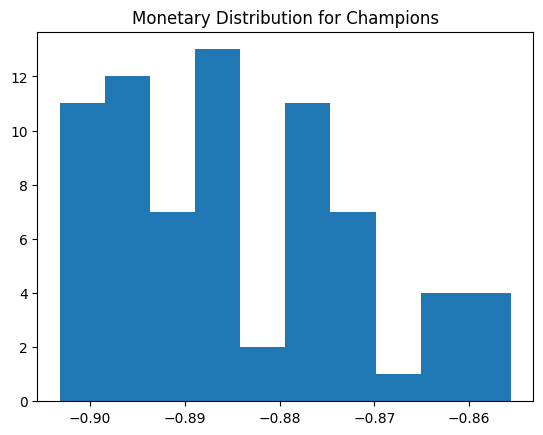

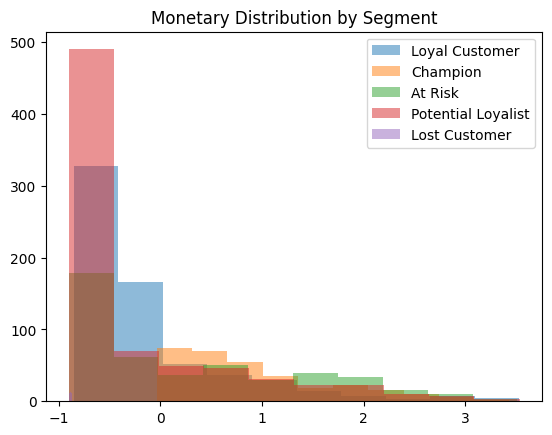

In [36]:
# Filter the data for the 'Loyal Customer' segment
Lost_Customer_segment = rm[rm['Segment'] == 'Lost Customer']

# Analyze the distribution of Income for Champions
Lost_Customer_income = Lost_Customer_segment['Monetary']
print(Lost_Customer_income.describe())  # Descriptive statistics
plt.hist(Lost_Customer_income)  # Histogram
plt.title('Monetary Distribution for Champions')
plt.show()

# Compare Income distribution of Champions with other segments
for segment in rm['Segment'].unique():
    segment_data = rm[rm['Segment'] == segment]
    plt.hist(segment_data['Monetary'], alpha=0.5, label=segment)
plt.title('Monetary Distribution by Segment')
plt.legend()
plt.show()

count     307.000000
mean     3922.605863
std        83.489839
min      3775.000000
25%      3855.000000
50%      3926.000000
75%      3997.000000
max      4059.000000
Name: Recency, dtype: float64


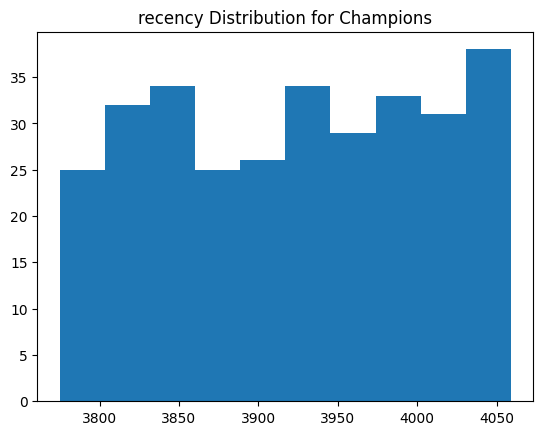

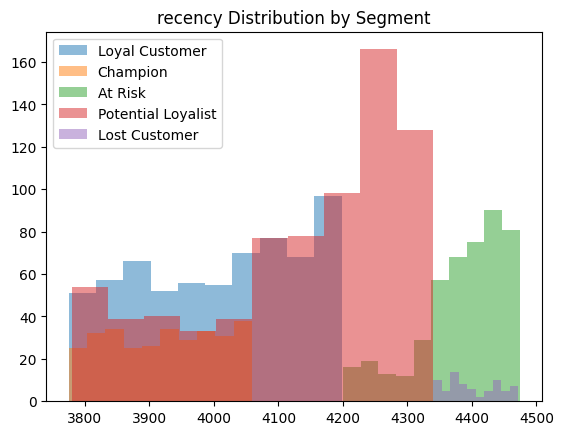

In [37]:
# Filter the data for the 'Champions' segment
champions_segment = rm[rm['Segment'] == 'Champion']

# Analyze the recency for Champions
champions_recency = champions_segment['Recency']
print(champions_recency.describe())  # Descriptive statistics
plt.hist(champions_recency)  # Histogram
plt.title('recency Distribution for Champions')
plt.show()

# Compare recency distribution of Champions with other segments
for segment in rm['Segment'].unique():
    segment_data = rm[rm['Segment'] == segment]
    plt.hist(segment_data['Recency'], alpha=0.5, label=segment)
plt.title('recency Distribution by Segment')
plt.legend()
plt.show()

In [38]:
at_risk_segment = data[rm['Segment'] == 'At Risk']

<ipython-input-39-61fd156cef78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_risk_segment['Age'] = current_year - at_risk_segment['Year_Birth']


count    460.000000
mean      55.126087
std       11.187128
min       29.000000
25%       47.000000
50%       55.000000
75%       64.000000
max       79.000000
Name: Age, dtype: float64


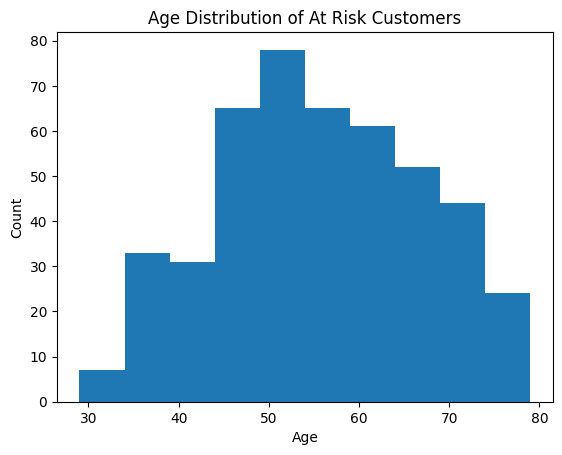

In [39]:
# Calculate age
current_year = datetime.datetime.now().year
at_risk_segment['Age'] = current_year - at_risk_segment['Year_Birth']

# Analyze age distribution
print(at_risk_segment['Age'].describe())
plt.hist(at_risk_segment['Age'])
plt.title('Age Distribution of At Risk Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<ipython-input-40-f6375fc5f9a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_risk_segment['Total_Kids'] = at_risk_segment['Kidhome'] + at_risk_segment['Teenhome']


count    460.000000
mean       0.928261
std        0.721039
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Total_Kids, dtype: float64


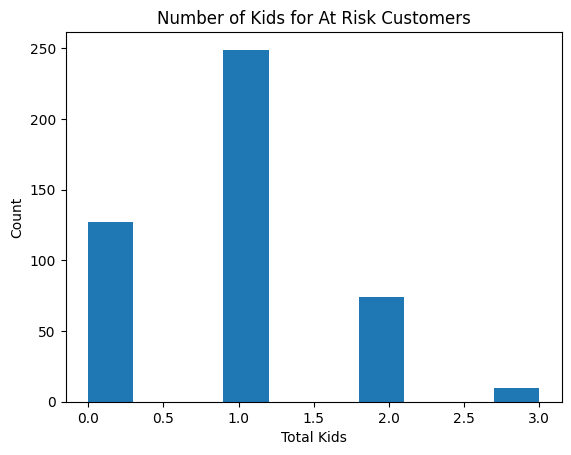

In [40]:
at_risk_segment['Total_Kids'] = at_risk_segment['Kidhome'] + at_risk_segment['Teenhome']
print(at_risk_segment['Total_Kids'].describe())
plt.hist(at_risk_segment['Total_Kids'])
plt.title('Number of Kids for At Risk Customers')
plt.xlabel('Total Kids')
plt.ylabel('Count')
plt.show()

In [41]:
champions_segment = data[rm['Segment'] == 'Champion']

<ipython-input-43-e23cc88078d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  champions_segment['Age'] = current_year - champions_segment['Year_Birth']


count    307.000000
mean      54.153094
std       11.706906
min       29.000000
25%       46.000000
50%       53.000000
75%       63.000000
max       84.000000
Name: Age, dtype: float64


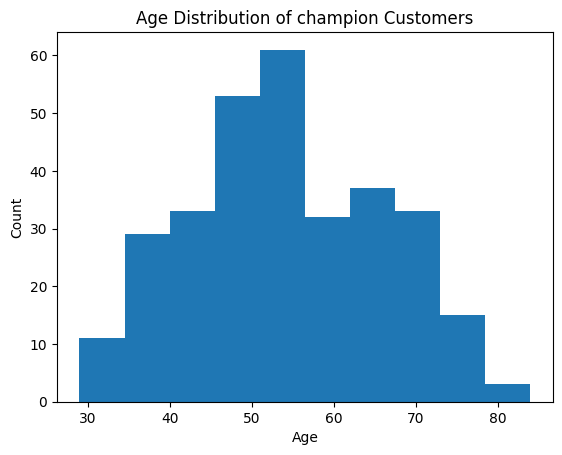

In [43]:
# Calculate age
current_year = datetime.datetime.now().year
champions_segment['Age'] = current_year - champions_segment['Year_Birth']

# Analyze age distribution
print(champions_segment['Age'].describe())
plt.hist(champions_segment['Age'])
plt.title('Age Distribution of champion Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<ipython-input-44-932071088b67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  champions_segment['Total_Kids'] = champions_segment['Kidhome'] + champions_segment['Teenhome']


count    307.000000
mean       0.902280
std        0.743311
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Total_Kids, dtype: float64


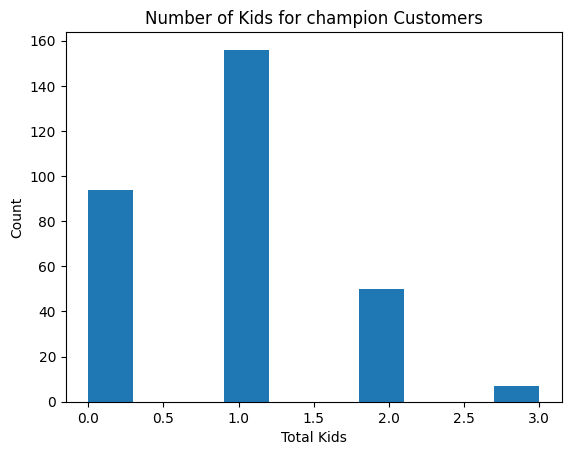

In [44]:
champions_segment['Total_Kids'] = champions_segment['Kidhome'] + champions_segment['Teenhome']
print(champions_segment['Total_Kids'].describe())
plt.hist(champions_segment['Total_Kids'])
plt.title('Number of Kids for champion Customers')
plt.xlabel('Total Kids')
plt.ylabel('Count')
plt.show()

In [45]:
lost_customer_segment = data[rm['Segment'] == 'Lost Customer']

<ipython-input-46-77fbef174125>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_customer_segment['Age'] = current_year - lost_customer_segment['Year_Birth']


count    72.000000
mean     53.652778
std      11.053213
min      33.000000
25%      46.000000
50%      51.000000
75%      61.250000
max      78.000000
Name: Age, dtype: float64


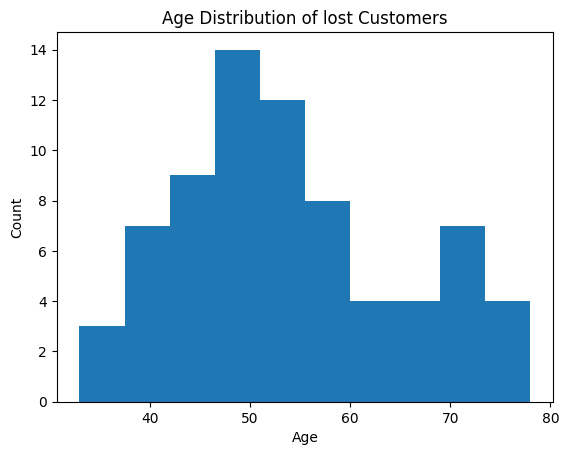

In [46]:
# Calculate age
current_year = datetime.datetime.now().year
lost_customer_segment['Age'] = current_year - lost_customer_segment['Year_Birth']

# Analyze age distribution
print(lost_customer_segment['Age'].describe())
plt.hist(lost_customer_segment['Age'])
plt.title('Age Distribution of lost Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<ipython-input-47-f8f0ee838443>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_customer_segment['Total_Kids'] = lost_customer_segment['Kidhome'] + lost_customer_segment['Teenhome']


count    72.000000
mean      0.930556
std       0.737838
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: Total_Kids, dtype: float64


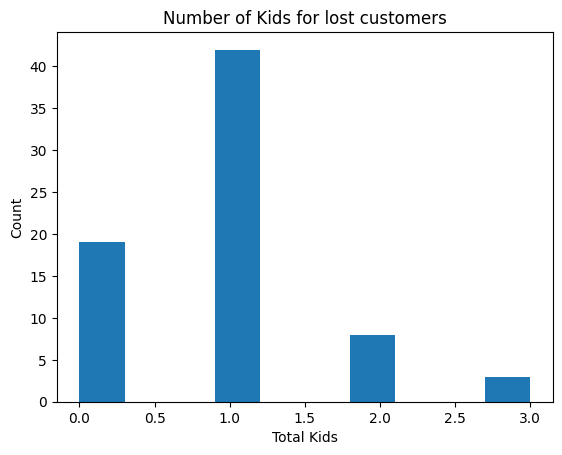

In [47]:
lost_customer_segment['Total_Kids'] = lost_customer_segment['Kidhome'] + lost_customer_segment['Teenhome']
print(lost_customer_segment['Total_Kids'].describe())
plt.hist(lost_customer_segment['Total_Kids'])
plt.title('Number of Kids for lost customers')
plt.xlabel('Total Kids')
plt.ylabel('Count')
plt.show()

In [48]:
print("Champions Income Statistics:")
print(champions_segment['Income'].describe())

print("\nLost Customer Income Statistics:")
print(lost_customer_segment['Income'].describe())

Champions Income Statistics:
count    307.000000
mean       0.112190
std        1.648437
min       -1.926105
25%       -0.615822
50%       -0.033875
75%        0.706287
max       24.545343
Name: Income, dtype: float64

Lost Customer Income Statistics:
count    72.000000
mean      0.067846
std       1.000621
min      -1.787205
25%      -0.672129
50%       0.061042
75%       0.772081
max       4.214345
Name: Income, dtype: float64


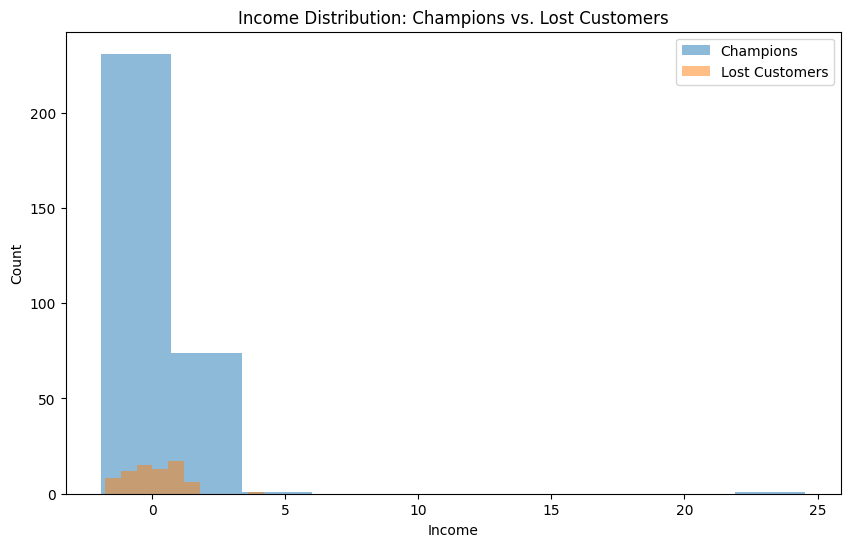

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(champions_segment['Income'], alpha=0.5, label='Champions')
plt.hist(lost_customer_segment['Income'], alpha=0.5, label='Lost Customers')
plt.title('Income Distribution: Champions vs. Lost Customers')
plt.xlabel('Income')
plt.ylabel('Count')
plt.legend()
plt.show()

In [50]:
for segment_name in rm['Segment'].unique():
    segment_data = data[rm['Segment'] == segment_name]
    print(f"\n{segment_name} Income Statistics:")
    print(segment_data['Income'].describe())


Loyal Customer Income Statistics:
count    649.000000
mean      -0.021206
std        0.831296
min       -2.017707
25%       -0.691224
50%       -0.034215
75%        0.649121
max        4.190895
Name: Income, dtype: float64

Champion Income Statistics:
count    307.000000
mean       0.112190
std        1.648437
min       -1.926105
25%       -0.615822
50%       -0.033875
75%        0.706287
max       24.545343
Name: Income, dtype: float64

At Risk Income Statistics:
count    460.000000
mean       0.016070
std        0.890602
min       -1.892629
25%       -0.676523
50%       -0.021172
75%        0.677953
max        4.400664
Name: Income, dtype: float64

Potential Loyalist Income Statistics:
count    752.000000
mean      -0.043825
std        0.831700
min       -1.989064
25%       -0.673607
50%       -0.062618
75%        0.580010
max        4.062182
Name: Income, dtype: float64

Lost Customer Income Statistics:
count    72.000000
mean      0.067846
std       1.000621
min      -1.787205
25%

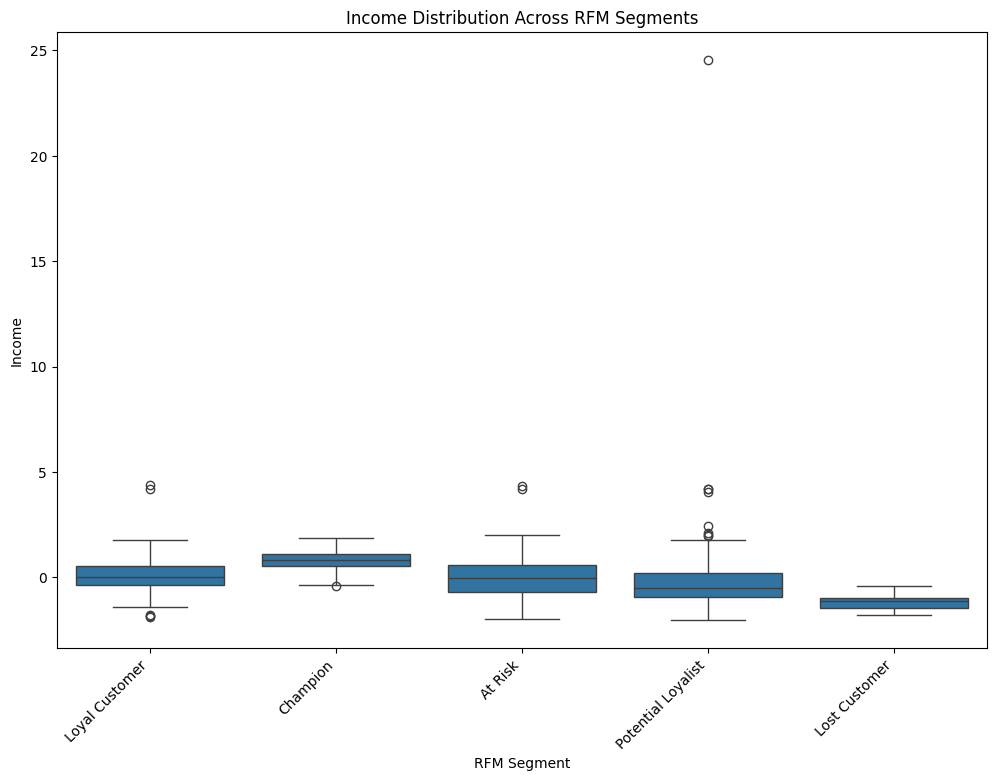

In [55]:
import pandas as pd
data = pd.merge(data, rm[['CustomerID', 'Segment']], left_on='ID', right_on='CustomerID', how='left')
plt.figure(figsize=(12, 8))
sns.boxplot(x='Segment', y='Income', data=data, order=rm['Segment'].unique())
plt.title('Income Distribution Across RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Income')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [57]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler on the 'Income' column of your original data (data)
scaler.fit(data[['Income']])

# Transform the 'Income' column in both your original data and the RFM dataframe
data['Income_Scaled'] = scaler.transform(data[['Income']])
rm = pd.merge(rm, data[['ID', 'Income_Scaled']], left_on='CustomerID', right_on='ID', how='left')


Loyal Customer Income_Scaled Statistics:
count    649.000000
mean       0.108226
std        0.680878
min       -1.861189
25%       -0.368242
50%        0.039750
75%        0.543617
max        4.400664
Name: Income_Scaled, dtype: float64

Champion Income_Scaled Statistics:
count    307.000000
mean       0.811659
std        0.437970
min       -0.400481
25%        0.519908
50%        0.828129
75%        1.112860
max        1.859154
Name: Income_Scaled, dtype: float64

At Risk Income_Scaled Statistics:
count    460.000000
mean      -0.025271
std        0.861795
min       -1.989064
25%       -0.673787
50%       -0.025206
75%        0.605517
max        4.336986
Name: Income_Scaled, dtype: float64

Potential Loyalist Income_Scaled Statistics:
count    752.000000
mean      -0.297056
std        1.240509
min       -2.017707
25%       -0.941101
50%       -0.502568
75%        0.195448
max       24.545343
Name: Income_Scaled, dtype: float64

Lost Customer Income_Scaled Statistics:
count    72.0000

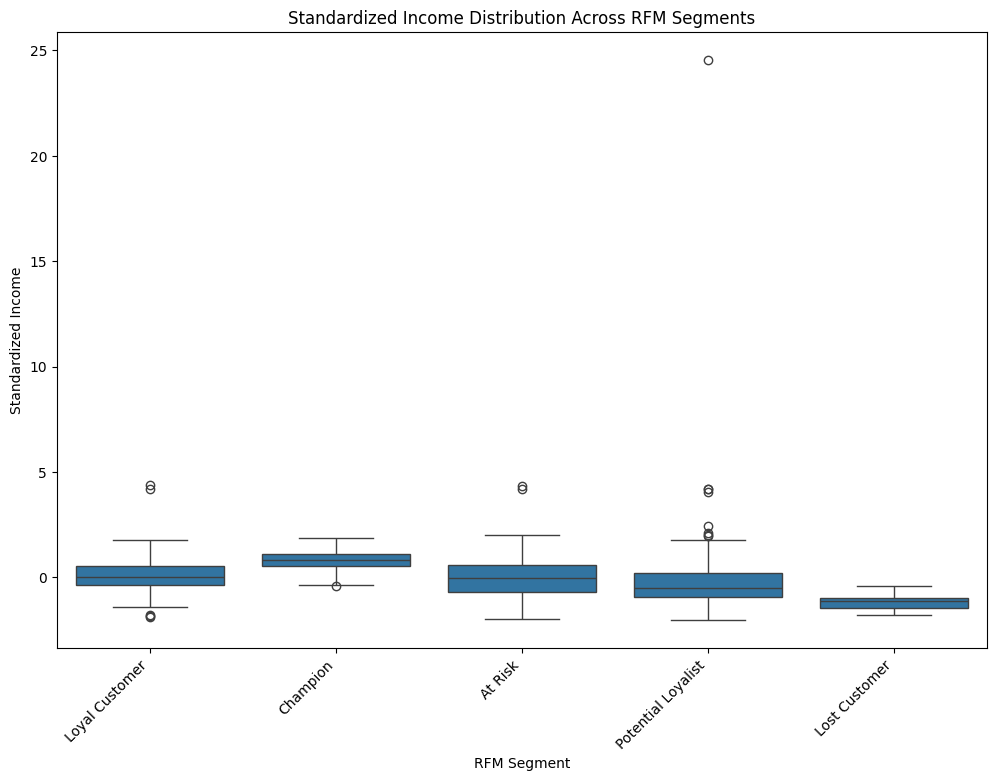

In [58]:
for segment_name in rm['Segment'].unique():
    segment_data = rm[rm['Segment'] == segment_name]
    print(f"\n{segment_name} Income_Scaled Statistics:")
    print(segment_data['Income_Scaled'].describe())

plt.figure(figsize=(12, 8))
sns.boxplot(x='Segment', y='Income_Scaled', data=rm, order=rm['Segment'].unique())
plt.title('Standardized Income Distribution Across RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Standardized Income')
plt.xticks(rotation=45, ha='right')
plt.show()

# Here's a breakdown of the key observations from the standardized income statistics:

##Champions:
This segment still exhibits the highest average standardized income (mean = 0.811659), reinforcing the observation that your most valuable customers tend to have higher income levels compared to other segments. The standard deviation (std = 0.437970) is lower than before standardization, indicating less variability in income within this segment after scaling.
##Loyal Customers:
This segment's average standardized income (mean = 0.108226) is positive, suggesting that their income is slightly above the overall average. The standard deviation is moderate (std = 0.680878), indicating a reasonable spread of income within this group.
##At Risk:
 This segment's average standardized income is slightly negative (mean = -0.025271), indicating income slightly below the overall average. The standard deviation is relatively high (std = 0.861795), suggesting a wider income range within this segment.
##Potential Loyalists:
 This segment has the lowest average standardized income (mean = -0.297056), indicating income significantly below the overall average. They also exhibit the highest standard deviation (std = 1.240509), suggesting a wide range of income within this group, including some potentially very low-income customers.
##Lost Customers:
 Interestingly, the Lost Customers segment now shows the second-lowest average standardized income (mean = -1.172316), indicating that these customers, on average, had significantly lower income compared to most other segments. The standard deviation is relatively low (std = 0.353245), suggesting less income variability within this segment after standardization.
#Changes after Standardization

##Segment Ranking:
 The relative income rankings of the segments have shifted slightly after standardization. While Champions still have the highest income, Lost Customers now have the second-lowest income, contrasting with the previous analysis where they had slightly higher income than Loyal Customers and Potential Loyalists.
##Magnitude of Differences:
 The differences in standardized income between segments appear more pronounced after standardization, highlighting the income disparities between customer groups more clearly.

#Overall Description of the Analysis

This analysis aimed to understand customer behavior and segment the customer base for targeted marketing using the marketing campaign dataset. The analysis involved the following key steps:

##Data Preparation:
 The initial dataset was loaded, cleaned, and preprocessed. Missing values were handled, and the 'Dt_Customer' column was converted to datetime format. Feature engineering was performed to calculate customer tenure.

##RFM Segmentation:
Rency, Frequency, and Monetary (RFM) analysis was conducted to segment customers into distinct groups based on their purchase behavior. Customers were categorized into Champions, Loyal Customers, Potential Loyalists, At Risk, and Lost Customers based on their RFM scores. **This segmentation approach was ultimately favored due to its interpretability and relevance to the business context.**

##K-means Clustering:
K-means clustering was also explored as an alternative segmentation method. **Parameters were fine-tuned to optimize cluster formation and achieve better results.** However, RFM segmentation proved to be more suitable for this specific dataset and analysis goals.

##Customer Profiling:
Detailed customer profiling was performed for each RFM segment to understand their characteristics, including age, marital status, number of kids, and income. Descriptive statistics and visualizations were used to analyze the distributions of these features within each segment.

##Income Standardization:
Income data was standardized to ensure comparability between segments and refine the analysis of income distributions. The standardized income analysis revealed more pronounced differences between segments and provided a more accurate basis for targeted marketing.

##Insights and Implications:
The analysis yielded valuable insights into the characteristics and behavior of different customer segments. These insights can be leveraged to develop targeted marketing strategies, personalize communication, and improve customer relationships.

#Key Findings:

**RFM segmentation effectively categorized customers into meaningful groups based on their purchase behavior.**

**K-means clustering was explored but ultimately deemed less suitable for this particular dataset and analysis goals.**

**Champions, Loyal Customers, Potential Loyalists, At Risk, and Lost Customers exhibited distinct characteristics and income profiles.**

###Champions:
This segment represents the most valuable customers, characterized by high recency, frequency, and monetary value, as well as higher income levels.
###Loyal Customers:
This segment exhibits consistent purchase behavior and moderate income levels.
###Potential Loyalists:
This segment shows potential for increased engagement and has slightly lower income levels.
###At Risk:
This segment has decreased engagement and requires targeted re-engagement strategies.
###Lost Customers:
This segment has churned and had significantly lower income levels after standardization.